In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize 

import warnings
warnings.filterwarnings("ignore")

# Import own libraries 
import os, sys
script_path = os.path.realpath(os.path.dirname("10_on_trajectories"))
os.chdir(script_path)
sys.path.append("..")

from myLibraries.queries import * 
from myLibraries.events import *
from myLibraries.theoretical_functions import *

In [2]:
HOLE_SIZE = 7
ACTIVITY = 5
MIN_PUBS = 3
EVENTS = get_collabs_eventACTIVE(HOLE_SIZE, ACTIVITY, MIN_PUBS)
ALL_EVENTS = get_allEvents(EVENTS)

YEARS = get_str_years_event()

# get rid of misleading years
YEARS_TO_CONSIDER = YEARS[11: -8]
EVENTS_TO_CONSIDER = YEARS[11: -8]

WINDOW = 5
SECTION = 8

In [3]:
curr_win = 0
windows_years = []
while len(YEARS)-SECTION >= WINDOW+curr_win-1:
    windows_years.append(YEARS[curr_win:WINDOW+curr_win])
    curr_win += 1
windows_years

[['1989', '1990', '1991', '1992', '1993'],
 ['1990', '1991', '1992', '1993', '1994'],
 ['1991', '1992', '1993', '1994', '1995'],
 ['1992', '1993', '1994', '1995', '1996'],
 ['1993', '1994', '1995', '1996', '1997'],
 ['1994', '1995', '1996', '1997', '1998'],
 ['1995', '1996', '1997', '1998', '1999'],
 ['1996', '1997', '1998', '1999', '2000'],
 ['1997', '1998', '1999', '2000', '2001'],
 ['1998', '1999', '2000', '2001', '2002'],
 ['1999', '2000', '2001', '2002', '2003'],
 ['2000', '2001', '2002', '2003', '2004'],
 ['2001', '2002', '2003', '2004', '2005'],
 ['2002', '2003', '2004', '2005', '2006'],
 ['2003', '2004', '2005', '2006', '2007'],
 ['2004', '2005', '2006', '2007', '2008'],
 ['2005', '2006', '2007', '2008', '2009'],
 ['2006', '2007', '2008', '2009', '2010'],
 ['2007', '2008', '2009', '2010', '2011']]

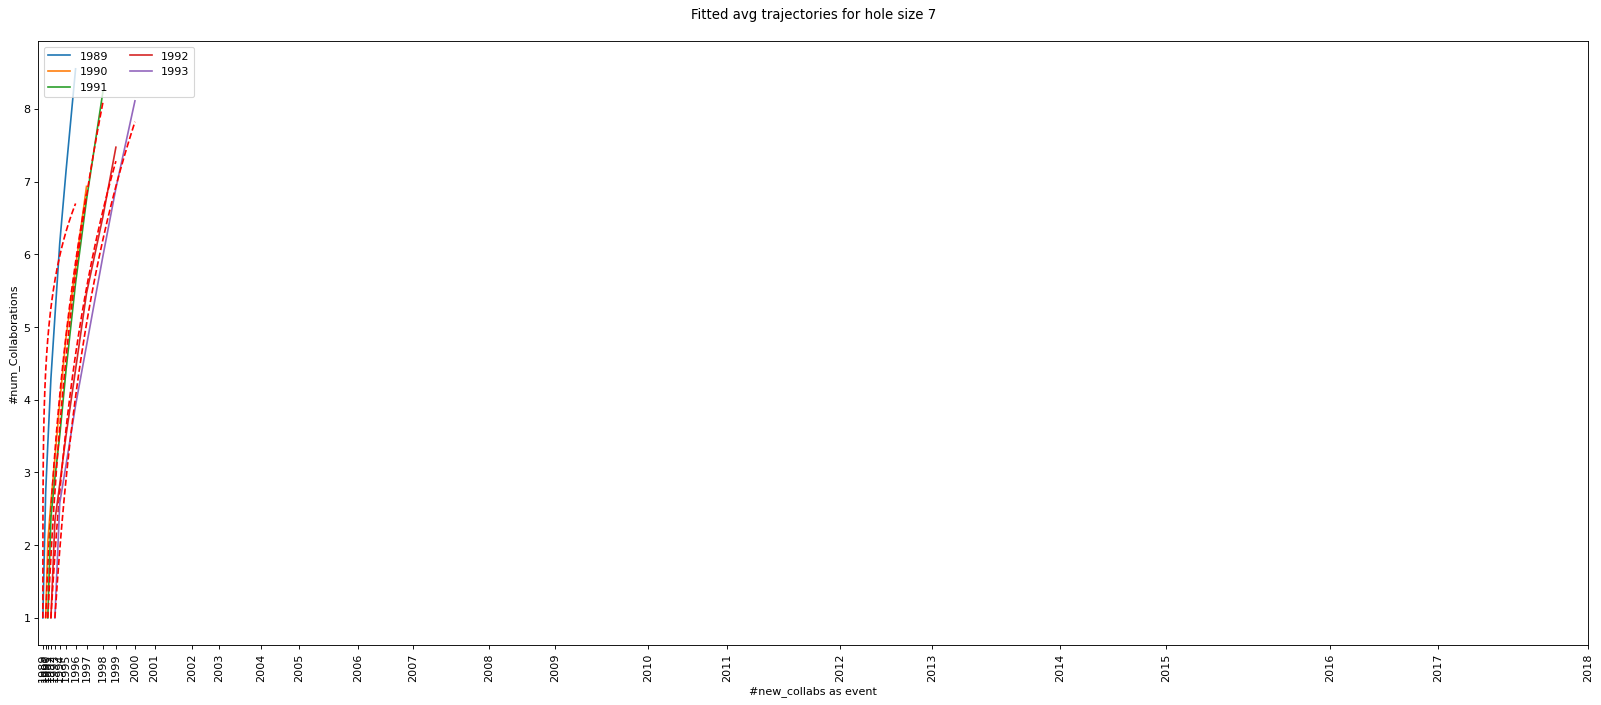

In [4]:
# plot a window of years and the given section of trajectories

curr_win = 0
while len(YEARS)-SECTION >= WINDOW+curr_win-1:
    ## Plot fitted average trajectories
    plt.figure(figsize=(25, 10), dpi=80)
    plt.title("Fitted avg trajectories for hole size " + str(HOLE_SIZE) + "\n", fontdict = {'fontsize' : 12})
    plt.xlabel("#new_collabs as event")
    plt.ylabel("#num_Collaborations")
    plt.xticks(rotation='vertical')

    alphas = []
    betas = []
    for start_y in YEARS[curr_win:WINDOW+curr_win]:
        
        
        x,y = get_avg_trajectories(EVENTS, HOLE_SIZE, start_y, section=SECTION, activity=ACTIVITY, minPubs=MIN_PUBS) # retrieve average trajecory for the given start_y (and hole size)     

        
        fit_y, alpha, beta = fit_trajectory(x, y) # fit the real data above with the theoretical trajectory 
        
        xdata = [a for a in range(x[0], x[-1])]
        fit_y = theoretical_func(xdata, alpha, beta, x[0])

        # save fitted parameters alpha, beta
        alphas.append(alpha)
        betas.append(beta)
        
        plt.plot(x,y, label=str(start_y))
        plt.plot(xdata, fit_y, 'r--')

    plt.xticks(rotation='vertical')    
    plt.legend(loc='upper left', ncol=2)
    plt.xticks(EVENTS, YEARS)
    plt.show()
    curr_win += 1
    
    break

In [5]:
##### ERRORS FUNCTIONS FOR AVERAGE TRAJECTORIES #####

## error function to minimize in order to find alpha* and beta*
    ## this function compare f* with real data 
def err_f_A(params, xdata, hole_size, years_to_consider=YEARS):
    opt_alpha, opt_beta = params
    err = 0
    for start_y in years_to_consider:
        i = YEARS.index(start_y)
        x,y = get_avg_trajectories(EVENTS, hole_size, start_y, section=SECTION, activity=ACTIVITY, minPubs=MIN_PUBS) # retrieve average trajecory for the given start_y (and hole size)     
        
        for curr_y in YEARS[i:][:i+SECTION]:
            e = YEARS.index(curr_y)
            try:
                err += pow(abs(theoretical_func(xdata[e], opt_alpha, opt_beta, xdata[i]) - y[YEARS[i:][:-1].index(curr_y)]), 2)
            except:
                0==0
    sys.stdout.write('\r'+ "optimizing A function with -> params: " + str(params) +", error: "+ str(err))
    return err

SUBSET_SIZE = 200 # the next error function works on all events, choose the number of event to be considered 

## error function to minimize in order to find alpha* and beta*
    ## this function compare f* with fitted data f_i 
        ## we consider a subset of events for computational costs
def err_f_C(params, xdata, hole_size, years_to_consider=YEARS):
    opt_alpha, opt_beta = params
    
    size = SUBSET_SIZE # subset of events to consider 
    
    all_events = [e for e in range(xdata[-1])]
    next_events = all_events
    n = (len(next_events))//size
        
    events_subset = [next_events[e] for e in range(len(next_events)) if e%n==0][:size]
        
    err = 0
    for start_y in years_to_consider:
        i = YEARS.index(start_y)    
        curr_x = xdata[i]  
        
        x,y = get_avg_trajectories(EVENTS, hole_size, start_y, section=SECTION, activity=ACTIVITY, minPubs=MIN_PUBS) # retrieve average trajecory for the given start_y (and hole size)     
        fit_y, alpha, beta = fit_trajectory(x, y) # fit the real data above with the theoretical trajectory 
        
        
        for e in events_subset:
            if(e>curr_x):
                try:
                    err += pow(abs(theoretical_func(e, opt_alpha, opt_beta, xdata[i]) - theoretical_func(e, alpha, beta, xdata[i])), 2)
                except:
                    0==0
    sys.stdout.write('\r'+ "optimizing C function with " + str(size) + " events -> params: " + str(params) +", error: "+ str(err))
    return err

In [6]:
# minimize errors

# store all variables for each window and type of error (A,C)
all_alphas = [] # all_alphas[i][1] is associated to error A for window i, all_alphas[i][2] is associated to error C for window i
all_betas = [] # same for betas
all_errs = [] #same for errors



curr_win = 0
while len(YEARS)-SECTION >= WINDOW+curr_win-1:
    

    ## optimize alpha* and beta* for each error function defined above 
    alphas_opt,betas_opt, errs = [],[],[]

    start_params = [1, 1]
    bnds = ((0, None), (1, None))

    # retrieve alpha* and beta* minimizing the associated function and
        # compute the error made by the optimized parameters 

    result_A = minimize(err_f_A, start_params, args=(EVENTS, HOLE_SIZE,  YEARS[curr_win:WINDOW+curr_win]), bounds=bnds)
    fitted_params_A = result_A.x
    alphas_opt.append(fitted_params_A[0])
    betas_opt.append(fitted_params_A[1])
    errs.append(err_f_A(fitted_params_A, EVENTS, HOLE_SIZE,  YEARS[curr_win:WINDOW+curr_win]))
    print()


    result_C = minimize(err_f_C, [1, 1], args=(EVENTS, HOLE_SIZE,  YEARS[curr_win:WINDOW+curr_win]), bounds=bnds)
    fitted_params_C = result_C.x
    alphas_opt.append(fitted_params_C[0])
    betas_opt.append(fitted_params_C[1])
    errs.append(err_f_C(fitted_params_C, EVENTS, HOLE_SIZE,  YEARS[curr_win:WINDOW+curr_win]))
    print()
        
        
    all_alphas.append(alphas_opt)
    all_betas.append(betas_opt)
    all_errs.append(errs)
    print(YEARS[curr_win:WINDOW+curr_win], "->", alphas_opt, betas_opt, errs )
    
    curr_win += 1
    


optimizing A function with -> params: [0.64252047 1.        ], error: 315.83477538932425
optimizing C function with 200 events -> params: [1.68092152 1.        ], error: 116469.18218973166
['1989', '1990', '1991', '1992', '1993'] -> [0.6425204711915499, 1.680921515208943] [1.0, 1.0] [315.83477538932425, 116469.1821897316]
optimizing A function with -> params: [2.47981129 1.03986746], error: 45.3973470089239408.344767
optimizing C function with 200 events -> params: [2.79547969 1.11792253], error: 4744.9055506348745
['1990', '1991', '1992', '1993', '1994'] -> [2.479811290292224, 2.795479693510395] [1.039867459759426, 1.1179225308832121] [45.3973470089239, 4744.9055506348]
optimizing A function with -> params: [3.2275486 1.       ], error: 38.59774744094579534
optimizing C function with 200 events -> params: [3.05400466 1.1009792 ], error: 3556.1200184732687
['1991', '1992', '1993', '1994', '1995'] -> [3.2275485997862714, 3.054004657490709] [1.0, 1.1009791951258836] [38.597747440945795, 

In [7]:
# print results for each window
curr_win = 0

alphas_A = []
alphas_C = []

betas_A = []
betas_C = []

errs_A = []
errs_C = []

while len(YEARS)-SECTION >= WINDOW+curr_win-1:
    
    alpha_A = all_alphas[curr_win][0]
    beta_A = all_betas[curr_win][0]
    err_A = all_errs[curr_win][0]
    
    # creates arrays to plot each parameter
    alphas_A.append(alpha_A)
    betas_A.append(beta_A)
    errs_A.append(err_A)

    alpha_C = all_alphas[curr_win][1]
    beta_C = all_betas[curr_win][1]
    err_C = all_errs[curr_win][1]
    
    # create arrays to plot each parameter 
    alphas_C.append(alpha_C)
    betas_C.append(beta_C)
    errs_C.append(err_C)
    
    print()
    print("="*15,windows_years[curr_win],"="*15 )
    print(pd.DataFrame([[[err_A, err_C][i], [alpha_A, alpha_C][i], [beta_A, beta_C][i]] for i in range(2)], ["A", "C"], ["ERROR", "alpha", "beta",]))
    
    curr_win += 1


=============== ['1989', '1990', '1991', '1992', '1993'] ===============
           ERROR     alpha  beta
A     315.834775  0.642520   1.0
C  116469.182190  1.680922   1.0

=============== ['1990', '1991', '1992', '1993', '1994'] ===============
         ERROR     alpha      beta
A    45.397347  2.479811  1.039867
C  4744.905551  2.795480  1.117923

=============== ['1991', '1992', '1993', '1994', '1995'] ===============
         ERROR     alpha      beta
A    38.597747  3.227549  1.000000
C  3556.120018  3.054005  1.100979

=============== ['1992', '1993', '1994', '1995', '1996'] ===============
         ERROR     alpha  beta
A    48.907064  3.733596   1.0
C  5641.857099  4.164666   1.0

=============== ['1993', '1994', '1995', '1996', '1997'] ===============
          ERROR     alpha  beta
A    113.231100  4.625937   1.0
C  16296.886017  4.857185   1.0

=============== ['1994', '1995', '1996', '1997', '1998'] ===============
          ERROR     alpha  beta
A     88.733436  5.258093 

## **ERROR A** -> alphas betas and errors for each window

In [8]:
print(pd.DataFrame([[windows_years[i], alphas_A[i], betas_A[i], errs_A[i]] for i in range(len(alphas_A))], columns=["window", "alpha", "beta", "error A"]))

                            window      alpha      beta     error A
0   [1989, 1990, 1991, 1992, 1993]   0.642520  1.000000  315.834775
1   [1990, 1991, 1992, 1993, 1994]   2.479811  1.039867   45.397347
2   [1991, 1992, 1993, 1994, 1995]   3.227549  1.000000   38.597747
3   [1992, 1993, 1994, 1995, 1996]   3.733596  1.000000   48.907064
4   [1993, 1994, 1995, 1996, 1997]   4.625937  1.000000  113.231100
5   [1994, 1995, 1996, 1997, 1998]   5.258093  1.000000   88.733436
6   [1995, 1996, 1997, 1998, 1999]   6.043890  1.000000   86.015274
7   [1996, 1997, 1998, 1999, 2000]   6.907860  1.000000   59.308019
8   [1997, 1998, 1999, 2000, 2001]   8.611239  1.000000  221.401225
9   [1998, 1999, 2000, 2001, 2002]   8.964712  1.000000  213.152739
10  [1999, 2000, 2001, 2002, 2003]  10.635242  1.000000  272.652060
11  [2000, 2001, 2002, 2003, 2004]  11.634065  1.000000  210.052291
12  [2001, 2002, 2003, 2004, 2005]  13.394332  1.000000  177.619443
13  [2002, 2003, 2004, 2005, 2006]  13.390073  1

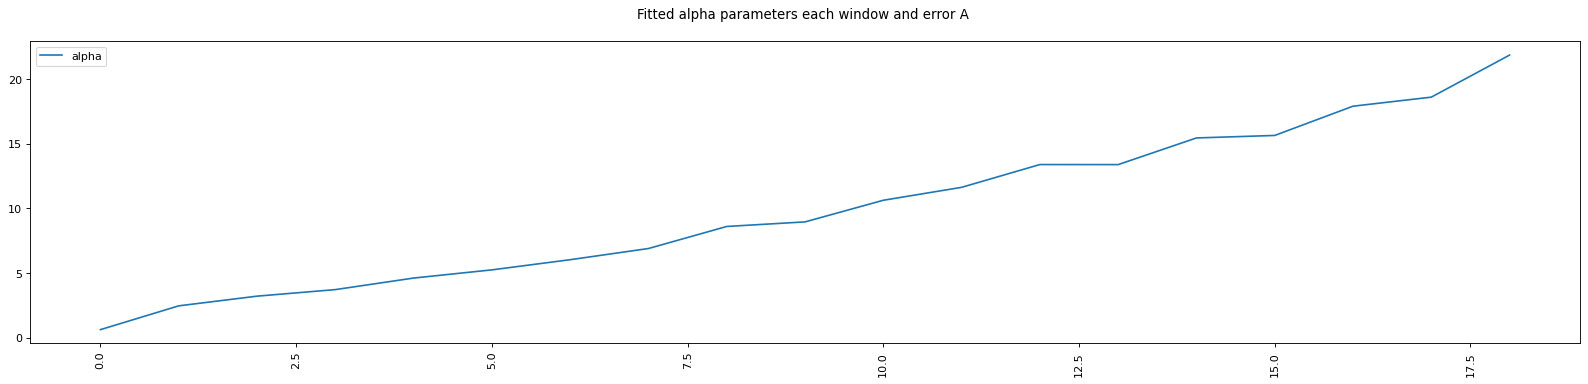

In [9]:
## Plotting fitted parameters alpha for each window
plt.figure(figsize=(25, 5), dpi=80)
plt.title("Fitted alpha parameters each window and error A \n", fontdict = {'fontsize' : 12})

plt.plot(alphas_A, label="alpha")

plt.xticks(rotation='vertical')
plt.legend()
plt.show()

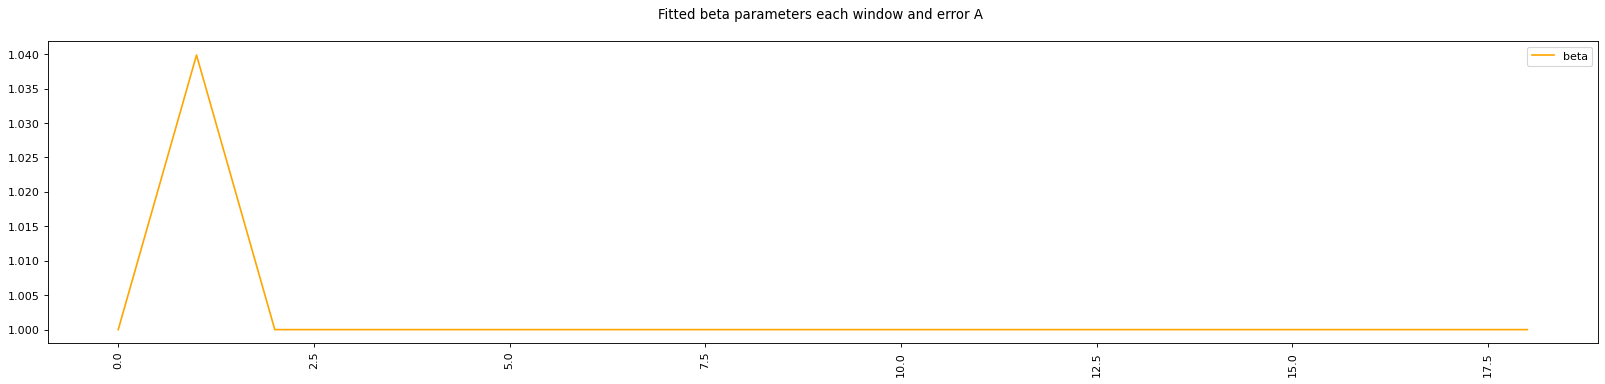

In [10]:
## Plotting fitted parameters beta for each window
plt.figure(figsize=(25, 5), dpi=80)
plt.title("Fitted beta parameters each window and error A \n", fontdict = {'fontsize' : 12})

plt.plot(betas_A, label="beta", color="orange")

plt.xticks(rotation='vertical')
plt.legend()
plt.show()

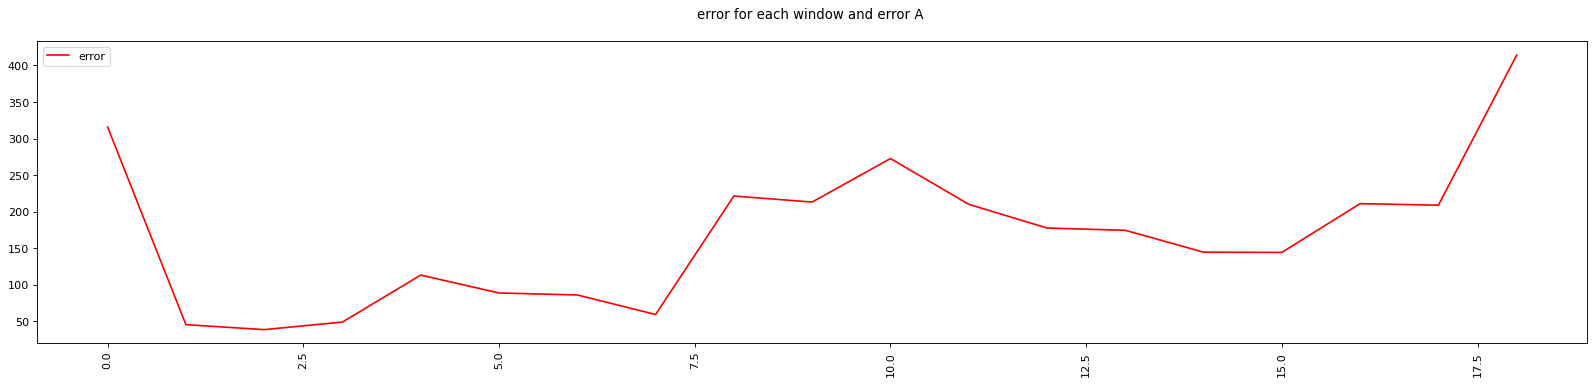

In [11]:
## Plotting error for each window
plt.figure(figsize=(25, 5), dpi=80)
plt.title("error for each window and error A \n", fontdict = {'fontsize' : 12})

plt.plot(errs_A, label="error", color="red")

plt.xticks(rotation='vertical')
plt.legend()
plt.show()

## **ERROR C** -> alphas betas and errors for each window

In [12]:
print(pd.DataFrame([[windows_years[i], alphas_C[i], betas_C[i], errs_C[i]] for i in range(len(alphas_A))], columns=["window", "alpha", "beta", "error B"]))

                            window      alpha      beta        error B
0   [1989, 1990, 1991, 1992, 1993]   1.680922  1.000000  116469.182190
1   [1990, 1991, 1992, 1993, 1994]   2.795480  1.117923    4744.905551
2   [1991, 1992, 1993, 1994, 1995]   3.054005  1.100979    3556.120018
3   [1992, 1993, 1994, 1995, 1996]   4.164666  1.000000    5641.857099
4   [1993, 1994, 1995, 1996, 1997]   4.857185  1.000000   16296.886017
5   [1994, 1995, 1996, 1997, 1998]   5.392140  1.000000   12396.764940
6   [1995, 1996, 1997, 1998, 1999]   5.968222  1.000000   14108.820976
7   [1996, 1997, 1998, 1999, 2000]   6.825733  1.000000    7909.599641
8   [1997, 1998, 1999, 2000, 2001]   8.262750  1.000000   26662.213671
9   [1998, 1999, 2000, 2001, 2002]   8.596449  1.000000   26030.916200
10  [1999, 2000, 2001, 2002, 2003]  10.192800  1.000000   29151.731420
11  [2000, 2001, 2002, 2003, 2004]  11.310162  1.000000   21234.077434
12  [2001, 2002, 2003, 2004, 2005]  13.104896  1.000000   13719.973595
13  [2

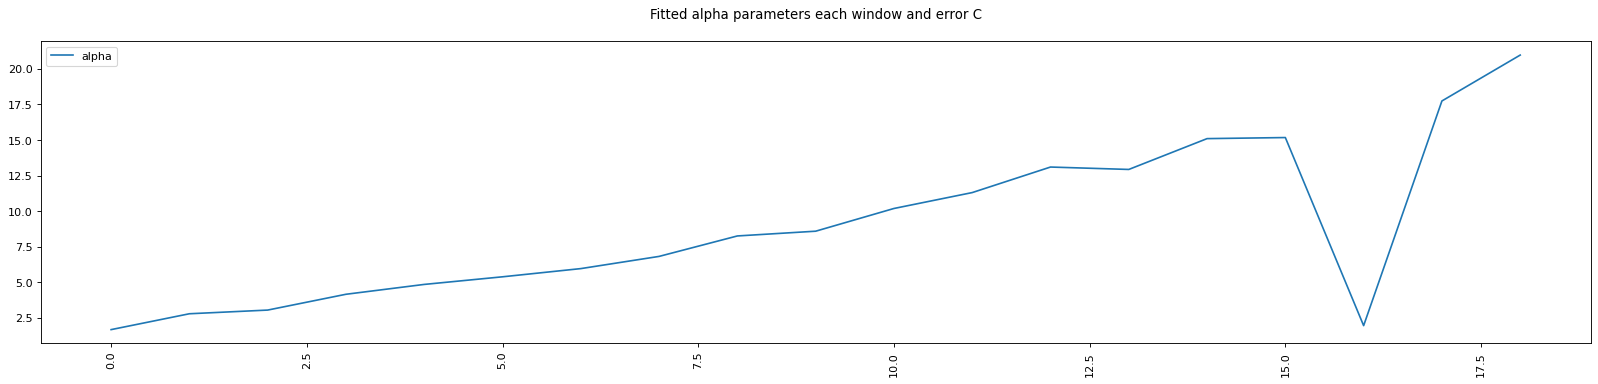

In [13]:
## Plotting fitted parameters alpha for each window
plt.figure(figsize=(25, 5), dpi=80)
plt.title("Fitted alpha parameters each window and error C\n", fontdict = {'fontsize' : 12})

plt.plot(alphas_C, label="alpha")

plt.xticks(rotation='vertical')
plt.legend()
plt.show()

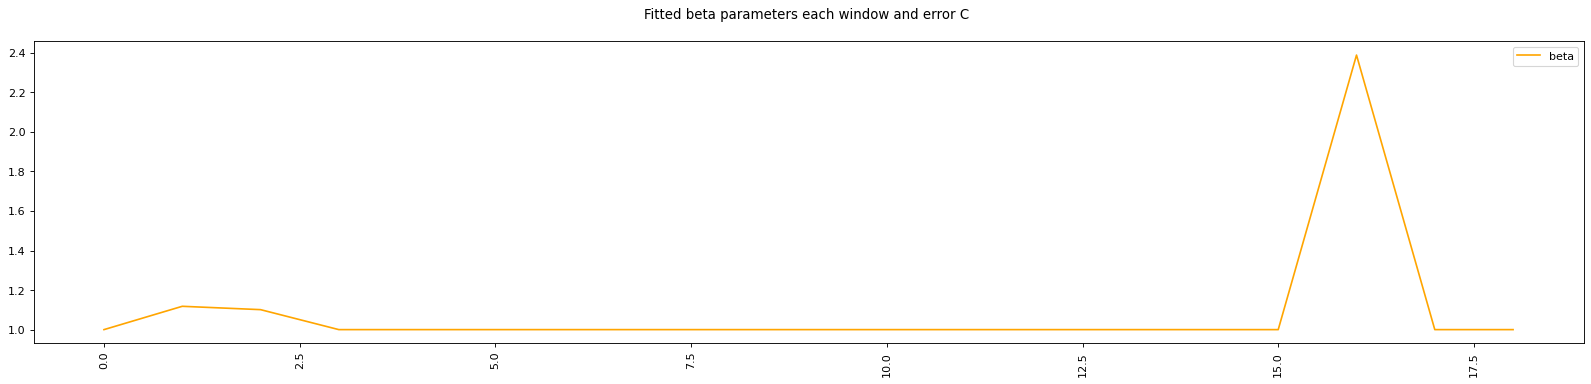

In [14]:
## Plotting fitted parameters beta for each window
plt.figure(figsize=(25, 5), dpi=80)
plt.title("Fitted beta parameters each window and error C \n", fontdict = {'fontsize' : 12})

plt.plot(betas_C, label="beta", color="orange")

plt.xticks(rotation='vertical')
plt.legend()
plt.show()

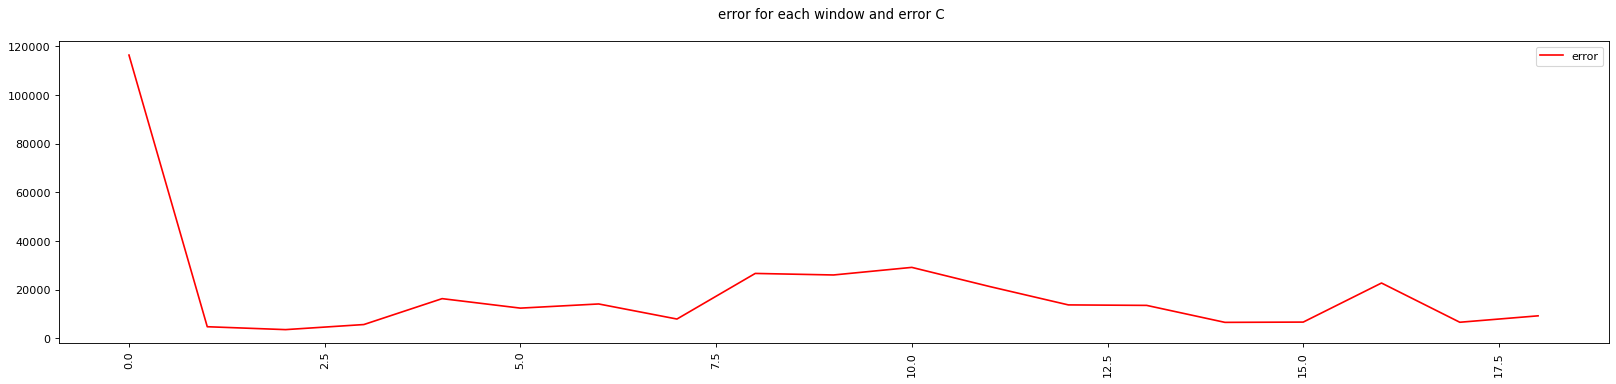

In [15]:
## Plotting error for each window
plt.figure(figsize=(25, 5), dpi=80)
plt.title("error for each window and error C \n", fontdict = {'fontsize' : 12})

plt.plot(errs_C, label="error", color="red")

plt.xticks(rotation='vertical')
plt.legend()
plt.show()